In [2]:
pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 445.1 kB/s eta 0:00:00


# Import Package & Data

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from category_encoders import TargetEncoder
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import xgboost as xgb
import pickle
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from xgboost import XGBRegressor
import os

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Exploration

In [5]:
df = pd.read_excel("/content/drive/MyDrive/Datathon 2025/Code/Model Xgboost/Quantity-Prediction Data.xlsx")
df.head()

,Date,Kategori,Tipe/Model,Demand,Past_Demand_1,Past_Demand_2,Moving_Average,Sales_Trend,Event,Event_Multiplier,Safety Percentage,Location
0,2020-01-01,Dispenser,Dispenser Portable,200.0,190.0,150.0,180.000000,0.052632,New_Year,1.2,0.30,Makassar
1,2020-01-01,Kipas Angin,Kipas Berdiri,100.0,90.0,85.0,91.666667,0.111111,New_Year,1.2,0.30,Surabaya
2,2020-01-01,Setrika,Setrika,100.0,90.0,120.0,103.333333,0.111111,New_Year,1.2,0.30,Medan
3,2020-01-02,Blender,Blender Kaca,385.0,160.0,100.0,215.000000,1.406250,No_Event,1.0,0.15,Batam
4,2020-01-02,Kipas Angin,Kipas Meja,150.0,125.0,100.0,125.000000,0.200000,No_Event,1.0,0.15,Batam


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5678 entries, 0 to 5677
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               5677 non-null   datetime64[ns]
 1   Kategori           5677 non-null   object        
 2   Tipe/Model         5677 non-null   object        
 3   Demand             5677 non-null   float64       
 4   Past_Demand_1      5677 non-null   float64       
 5   Past_Demand_2      5677 non-null   float64       
 6   Moving_Average     5677 non-null   float64       
 7   Sales_Trend        5678 non-null   float64       
 8   Event              5677 non-null   object        
 9   Event_Multiplier   5677 non-null   float64       
 10  Safety Percentage  5677 non-null   float64       
 11  Location           5678 non-null   object        
dtypes: datetime64[ns](1), float64(7), object(4)
memory usage: 532.4+ KB


In [7]:
df.isnull().sum()

,0
Date,1
Kategori,1
Tipe/Model,1
Demand,1
Past_Demand_1,1
Past_Demand_2,1
Moving_Average,1
Sales_Trend,0
Event,1
Event_Multiplier,1


In [8]:
df[['Demand','Past_Demand_1', 'Past_Demand_2', 'Moving_Average','Sales_Trend','Event_Multiplier', 'Safety Percentage']].describe()

,Demand,Past_Demand_1,Past_Demand_2,Moving_Average,Sales_Trend,Event_Multiplier,Safety Percentage
count,5677.000000,5677.000000,5677.000000,5677.000000,5678.000000,5677.000000,5677.000000
mean,354.293289,345.274969,340.100581,346.556280,0.263443,1.013158,0.158834
std,192.418250,191.069022,190.569962,146.104288,0.938462,0.062493,0.041381
min,30.000000,30.000000,25.000000,35.000000,-0.882658,1.000000,0.150000
25%,210.000000,203.000000,198.000000,245.333333,-0.304348,1.000000,0.150000
50%,315.000000,305.000000,299.000000,326.000000,0.014286,1.000000,0.150000
75%,454.000000,444.000000,435.000000,421.666667,0.523490,1.000000,0.150000
max,996.000000,996.000000,996.000000,949.333333,8.267606,1.500000,0.450000


In [9]:
df['Safety_Percentage'] = df['Safety Percentage'].astype(float) / 100
df.drop(columns=['Safety Percentage'], inplace=True)

In [10]:
df[['Kategori','Tipe/Model','Event','Location']].describe()

,Kategori,Tipe/Model,Event,Location
count,5677,5677,5677,5678
unique,10,46,9,10
top,Vacuum Cleaner,Setrika,No_Event,Makassar
freq,644,632,5421,601


In [11]:
# Menampilkan nilai unik untuk semua kolom kategorik
categorical_columns = df.select_dtypes(include=['object']).columns

for col in categorical_columns:
    print(f"Nilai unik di kolom {col}:")
    print(df[col].unique())
    print()  # Line break


Nilai unik di kolom Kategori:
['Dispenser' 'Kipas Angin' 'Setrika' 'Blender' 'Televisi' 'Vacuum Cleaner'
 'Microwave' 'AC (Air Conditioner)' 'Mesin Cuci' 'Kulkas' nan]

Nilai unik di kolom Tipe/Model:
['Dispenser Portable' 'Kipas Berdiri' 'Setrika' 'Blender Kaca'
 'Kipas Meja' 'QLED 65"' 'Canister Vacuum' 'LED 24"' 'Solo Microwave'
 'Grill Microwave' 'Split 0.5 PK' 'Handheld Vacuum' 'Top Loading'
 'Robot Vacuum' 'LED 43"' 'Blender Plastik' 'Portable AC 1 PK'
 'Cassette 2 PK' 'Hot & Cool' 'Twin Tub 9kg' 'Inverter Microwave'
 'Digital Microwave' 'Side-by-side' 'OLED 55"' 'Showcase' 'Kulkas Mini'
 'Smart TV 50"' 'Bottom Loading (Galon Bawah)' 'Wet & Dry Vacuum'
 '2 in 1 Blender' 'Top Load 8kg' '1 Pintu' 'Inverter 2 Pintu'
 'Mini Blender' 'Inverter 9kg' 'Split 1.5 PK Inverter' 'Stick Vacuum'
 'Kipas Remote Control' 'Standing Floor 2.5 PK' 'Top Load 6kg' 'LED 32"'
 'Front Load 10kg' 'Split 1 PK' 'Kipas Dinding' '2 Pintu' 'Front Load 7kg'
 nan]

Nilai unik di kolom Event:
['New_Year' 'No_Eve

In [12]:
num_data = df[['Demand', 'Past_Demand_1', 'Past_Demand_2', 'Moving_Average', 'Sales_Trend', 'Event_Multiplier', 'Safety_Percentage']]
cat_data = df[['Kategori', 'Tipe/Model', 'Event', 'Location']]

# Visualisasi Data

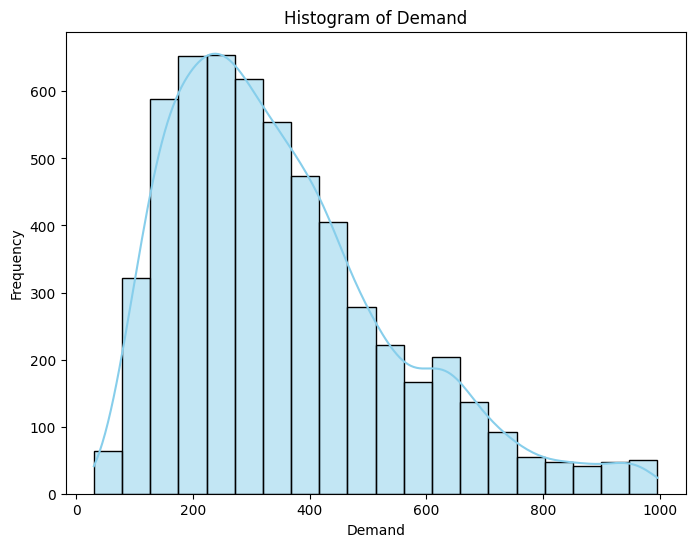

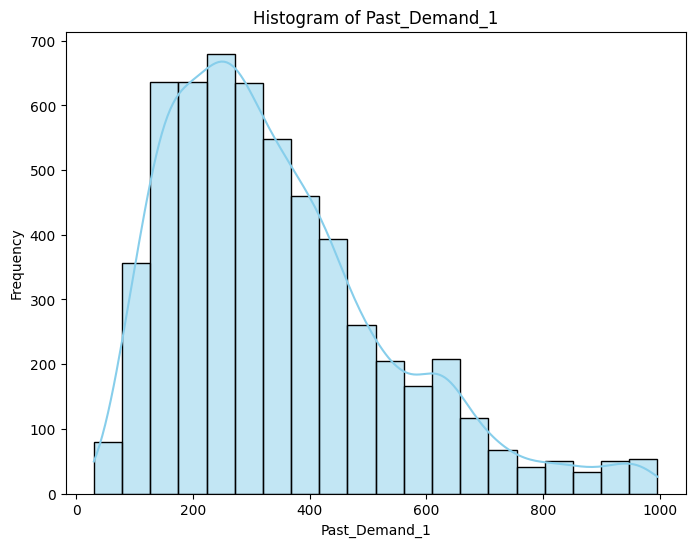

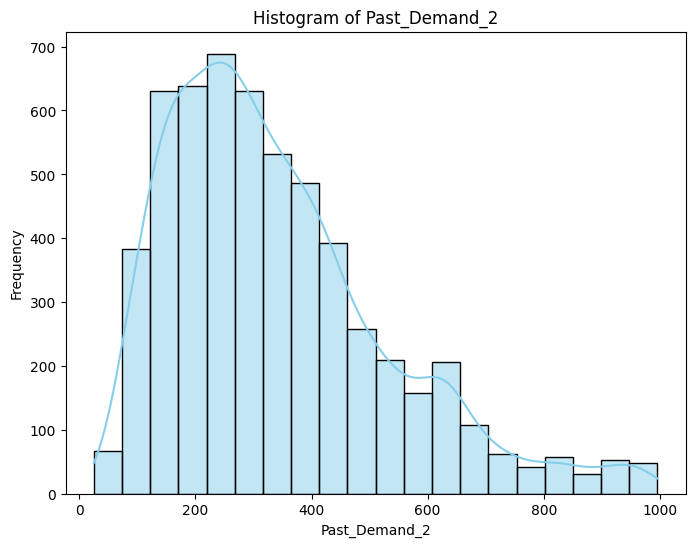

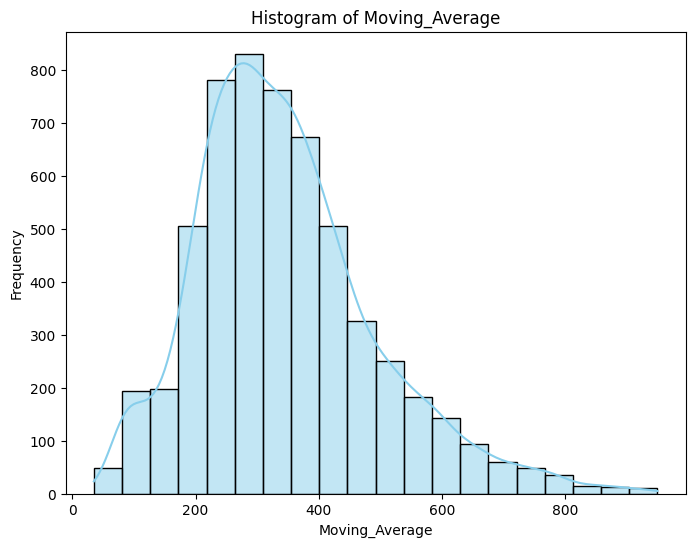

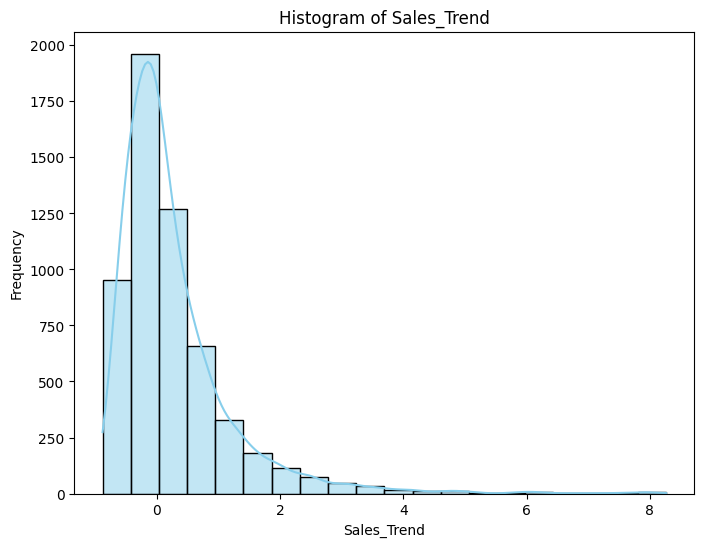

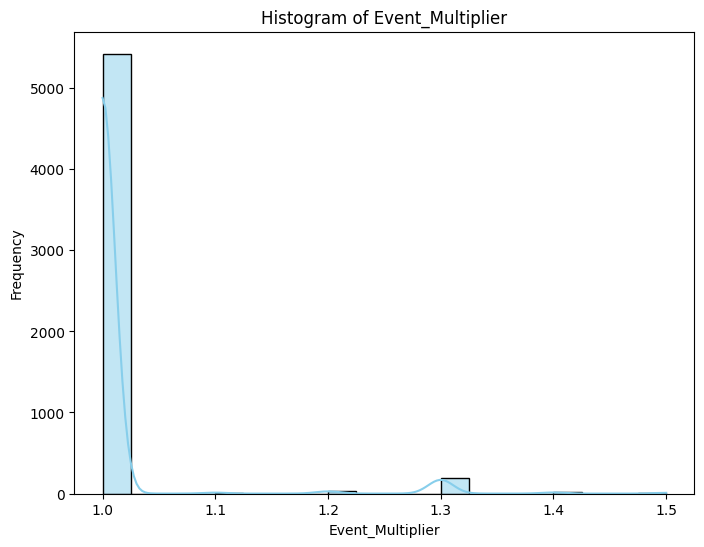

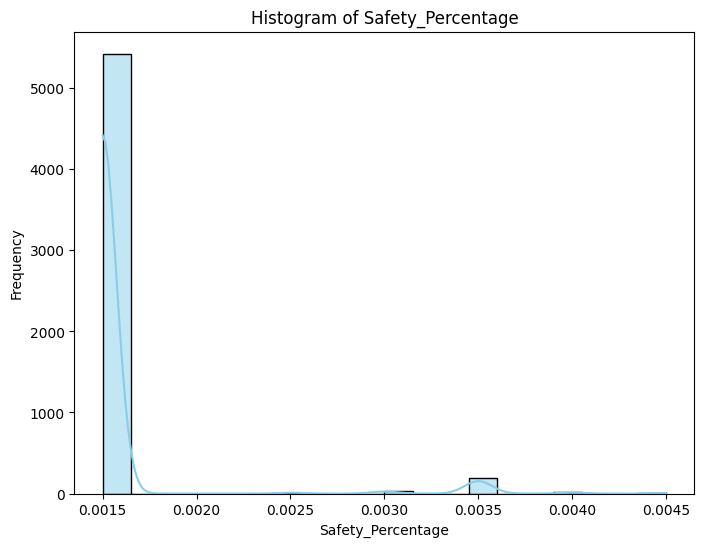

In [13]:
for col in num_data:
  plt.figure(figsize=(8,6))
  sns.histplot(data=df, x=col, kde=True, bins=20, color='skyblue')
  plt.title(f'Histogram of {col}')
  plt.xlabel(col)
  plt.ylabel('Frequency')
  plt.show()

# Feature Engineering

In [14]:
# df['Event_Demand_Estimated'] = df['Moving_Average'] * df['Event_Multiplier']

# Data Wrangling

In [15]:
# delete missing data
df = df.dropna()
df

,Date,Kategori,Tipe/Model,Demand,Past_Demand_1,Past_Demand_2,Moving_Average,Sales_Trend,Event,Event_Multiplier,Location,Safety_Percentage
0,2020-01-01,Dispenser,Dispenser Portable,200.0,190.0,150.0,180.000000,0.052632,New_Year,1.2,Makassar,0.0030
1,2020-01-01,Kipas Angin,Kipas Berdiri,100.0,90.0,85.0,91.666667,0.111111,New_Year,1.2,Surabaya,0.0030
2,2020-01-01,Setrika,Setrika,100.0,90.0,120.0,103.333333,0.111111,New_Year,1.2,Medan,0.0030
3,2020-01-02,Blender,Blender Kaca,385.0,160.0,100.0,215.000000,1.406250,No_Event,1.0,Batam,0.0015
4,2020-01-02,Kipas Angin,Kipas Meja,150.0,125.0,100.0,125.000000,0.200000,No_Event,1.0,Batam,0.0015
...,...,...,...,...,...,...,...,...,...,...,...,...
5672,2025-06-12,AC (Air Conditioner),Standing Floor 2.5 PK,103.0,158.0,381.0,214.000000,-0.348101,No_Event,1.0,Surabaya,0.0015
5673,2025-06-13,Mesin Cuci,Top Load 6kg,163.0,103.0,158.0,141.333333,0.582524,No_Event,1.0,Jakarta,0.0015
5674,2025-06-13,Kulkas,1 Pintu,255.0,188.0,212.0,218.333333,0.356383,No_Event,1.0,Sidoarjo,0.0015
5675,2025-06-14,Setrika,Setrika,274.0,220.0,199.0,231.000000,0.245455,No_Event,1.0,Batam,0.0015


In [16]:
for col in num_data:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    num_outliers = outliers.shape[0]

    print(f"Kolom '{col}': {num_outliers} outlier")

Kolom 'Demand': 165 outlier
Kolom 'Past_Demand_1': 187 outlier
Kolom 'Past_Demand_2': 195 outlier
Kolom 'Moving_Average': 167 outlier
Kolom 'Sales_Trend': 358 outlier
Kolom 'Event_Multiplier': 256 outlier
Kolom 'Safety_Percentage': 256 outlier


In [17]:
df.duplicated().sum()

np.int64(0)

# Encoding

In [18]:
def encode_event(df):
    # Definisikan event_rank di dalam fungsi dan kembalikan juga mapping-nya
    event_rank = {'No_Event': 0, 'New_Year': 3, 'Imlek': 2, 'Natal': 3, 'Idul_Fitri': 3, 'Nyepi': 2}
    encoded_values = df['Event'].map(event_rank).values.reshape(-1, 1)
    return encoded_values, event_rank  # Kembalikan kedua nilai

# Asumsikan df adalah DataFrame Anda
df['Event_encoded'], event_rank = encode_event(df)  # Terima return value


In [19]:
df

,Date,Kategori,Tipe/Model,Demand,Past_Demand_1,Past_Demand_2,Moving_Average,Sales_Trend,Event,Event_Multiplier,Location,Safety_Percentage,Event_encoded
0,2020-01-01,Dispenser,Dispenser Portable,200.0,190.0,150.0,180.000000,0.052632,New_Year,1.2,Makassar,0.0030,3.0
1,2020-01-01,Kipas Angin,Kipas Berdiri,100.0,90.0,85.0,91.666667,0.111111,New_Year,1.2,Surabaya,0.0030,3.0
2,2020-01-01,Setrika,Setrika,100.0,90.0,120.0,103.333333,0.111111,New_Year,1.2,Medan,0.0030,3.0
3,2020-01-02,Blender,Blender Kaca,385.0,160.0,100.0,215.000000,1.406250,No_Event,1.0,Batam,0.0015,0.0
4,2020-01-02,Kipas Angin,Kipas Meja,150.0,125.0,100.0,125.000000,0.200000,No_Event,1.0,Batam,0.0015,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5672,2025-06-12,AC (Air Conditioner),Standing Floor 2.5 PK,103.0,158.0,381.0,214.000000,-0.348101,No_Event,1.0,Surabaya,0.0015,0.0
5673,2025-06-13,Mesin Cuci,Top Load 6kg,163.0,103.0,158.0,141.333333,0.582524,No_Event,1.0,Jakarta,0.0015,0.0
5674,2025-06-13,Kulkas,1 Pintu,255.0,188.0,212.0,218.333333,0.356383,No_Event,1.0,Sidoarjo,0.0015,0.0
5675,2025-06-14,Setrika,Setrika,274.0,220.0,199.0,231.000000,0.245455,No_Event,1.0,Batam,0.0015,0.0


In [20]:
# Inisialisasi encoder
le_kategori = LabelEncoder()
le_location = LabelEncoder()
te_tipe_model = TargetEncoder()

In [21]:
# Fit transform
df['Kategori_encoded'] = le_kategori.fit_transform(df['Kategori'])
df['Location_encoded'] = le_location.fit_transform(df['Location'])
df['Tipe/Model_encoded'] = te_tipe_model.fit_transform(df['Tipe/Model'], df['Demand'])


In [22]:
df

,Date,Kategori,Tipe/Model,Demand,Past_Demand_1,Past_Demand_2,Moving_Average,Sales_Trend,Event,Event_Multiplier,Location,Safety_Percentage,Event_encoded,Kategori_encoded,Location_encoded,Tipe/Model_encoded
0,2020-01-01,Dispenser,Dispenser Portable,200.0,190.0,150.0,180.000000,0.052632,New_Year,1.2,Makassar,0.0030,3.0,2,4,365.925797
1,2020-01-01,Kipas Angin,Kipas Berdiri,100.0,90.0,85.0,91.666667,0.111111,New_Year,1.2,Surabaya,0.0030,3.0,3,8,331.047361
2,2020-01-01,Setrika,Setrika,100.0,90.0,120.0,103.333333,0.111111,New_Year,1.2,Medan,0.0030,3.0,7,5,351.327532
3,2020-01-02,Blender,Blender Kaca,385.0,160.0,100.0,215.000000,1.406250,No_Event,1.0,Batam,0.0015,0.0,1,0,339.976394
4,2020-01-02,Kipas Angin,Kipas Meja,150.0,125.0,100.0,125.000000,0.200000,No_Event,1.0,Batam,0.0015,0.0,3,0,353.912010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5672,2025-06-12,AC (Air Conditioner),Standing Floor 2.5 PK,103.0,158.0,381.0,214.000000,-0.348101,No_Event,1.0,Surabaya,0.0015,0.0,0,8,382.264421
5673,2025-06-13,Mesin Cuci,Top Load 6kg,163.0,103.0,158.0,141.333333,0.582524,No_Event,1.0,Jakarta,0.0015,0.0,5,3,343.820618
5674,2025-06-13,Kulkas,1 Pintu,255.0,188.0,212.0,218.333333,0.356383,No_Event,1.0,Sidoarjo,0.0015,0.0,4,7,360.199271
5675,2025-06-14,Setrika,Setrika,274.0,220.0,199.0,231.000000,0.245455,No_Event,1.0,Batam,0.0015,0.0,7,0,351.327532


# Train Model

In [23]:
df_model = df.drop(['Kategori', 'Date', 'Event', 'Tipe/Model', 'Latitude', 'Longitude', 'Location'], axis=1, errors='ignore')
df_model

,Demand,Past_Demand_1,Past_Demand_2,Moving_Average,Sales_Trend,Event_Multiplier,Safety_Percentage,Event_encoded,Kategori_encoded,Location_encoded,Tipe/Model_encoded
0,200.0,190.0,150.0,180.000000,0.052632,1.2,0.0030,3.0,2,4,365.925797
1,100.0,90.0,85.0,91.666667,0.111111,1.2,0.0030,3.0,3,8,331.047361
2,100.0,90.0,120.0,103.333333,0.111111,1.2,0.0030,3.0,7,5,351.327532
3,385.0,160.0,100.0,215.000000,1.406250,1.0,0.0015,0.0,1,0,339.976394
4,150.0,125.0,100.0,125.000000,0.200000,1.0,0.0015,0.0,3,0,353.912010
...,...,...,...,...,...,...,...,...,...,...,...
5672,103.0,158.0,381.0,214.000000,-0.348101,1.0,0.0015,0.0,0,8,382.264421
5673,163.0,103.0,158.0,141.333333,0.582524,1.0,0.0015,0.0,5,3,343.820618
5674,255.0,188.0,212.0,218.333333,0.356383,1.0,0.0015,0.0,4,7,360.199271
5675,274.0,220.0,199.0,231.000000,0.245455,1.0,0.0015,0.0,7,0,351.327532


In [24]:
X = df_model.drop('Demand', axis=1)
y = df_model['Demand']

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
XGB_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='mae',
    early_stopping_rounds=10,
    random_state=42
)

XGB_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric='mae', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [27]:
y_pred = XGB_model.predict(X_test)

In [28]:
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error (MAE): {mae:.2f}')

mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error (MSE): {mse:.2f}')

rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')

r2 = r2_score(y_test, y_pred)
print(f'R-squared (R²): {r2:.4f}')

mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

Mean Absolute Error (MAE): 9.52
Mean Squared Error (MSE): 190.26
Root Mean Squared Error (RMSE): 13.79
R-squared (R²): 0.9948
Mean Absolute Percentage Error (MAPE): 3.02%


# Save Model & Encoder

In [29]:
# Ensure the directories exist before saving
os.makedirs('model', exist_ok=True)
os.makedirs('encoder', exist_ok=True)

# Simpan model
# The variable holding your trained XGBoost model is XGB_model, not model.
joblib.dump(XGB_model, 'model/xgboost.joblib')

# Simpan encoder
# The variable holding your LabelEncoder is le, not label_encoder.
# The variable holding your TargetEncoder is te, not target_encoder.
joblib.dump(le_kategori, 'le_kategori.pkl')
joblib.dump(le_location, 'le_location.pkl')
joblib.dump(te_tipe_model, 'te_tipe_model.pkl')

# Simpan manual mapping
# The variable holding your event mapping is event_rank.
with open('encoder/event_rank.pkl', 'wb') as f:
    pickle.dump(event_rank, f)

In [30]:
XGB_model.save_model('model/xgboost.model')

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:33:08] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
